In [23]:
## Init Bionic VTOL
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode
create_visualization();

# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()
### Create Reinforcement Learning Environment

##### first coordinate - red axis - x
##### second coordinate - green axis - y
##### third coordinate - blue axis - z


const NUM_WAYPOINTS = 2;
const INITIAL_POSITION = [0.0, 0.0, 0.0];
const INITIAL_ROTATION = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0];
const SAMPLE_WAYPOINTS = [[0.0, 0.0, 0.0], [-10.0, 0.0, 5.0]];

w_max = 25.0; #maximum rotational speed before getting punished
timeout = 15.0; # simulation end time 
floor_level = -10.0; #as in aviation
v_expected = 3.0; #maximum speed before getting punished

######################################################################
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environments
    visualization::Bool # visualization
    realtime::Bool # realtime

    x_previous::Vector{T} # previous position
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    w_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    delta_t::T # simulation time step

    ################################ TODO ################################
    # Extend the environment here.
    # Everything you need additionaly in your environment also go in here.
    # E.g. a trajectory

    waypoints::Vector{Vector{T}} # waypoints
    proximity_tolerance::T # proximity tolerance
    v_min::T # minimum required velocity
    v_max::T # maximum allowed velocity

    ######################################################################
end


# define a keyword-based constructor for the type declared in the mutable struct typedef.
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # random number generation
    name = "vtol",
            visualization = false,
    realtime = false,
    kwargs...) # let the function take an arbitrary number of keyword arguments

    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    A = Space{Vector{ClosedInterval{T}}};

    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ],
    ) # propeller 1 and 2

    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            ################################ TODO ################################
            # Implement an observation space.
            # Here is an example space. You can change it if desired.
            # You have to extend it.
            # Orientate yourself on the observation space from the paper.

            typemin(T)..typemax(T), # previous position along x WORLD coordinates
            typemin(T)..typemax(T), # previous position along z WORLD coordinates

            typemin(T)..typemax(T), # current position along x WORLD coordinates
            typemin(T)..typemax(T), # current position along z WORLD coordinates

            typemin(T)..typemax(T), # orientation along x WORLD coordinates
            typemin(T)..typemax(T), # orientation along z WORLD coordinates

            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates

            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates

            #changed back to world for calculating guiding path easier
            typemin(T)..typemax(T), # position of target along x WORLD coordinates
            typemin(T)..typemax(T), # position of target along z WORLD coordinates

            #changed so the drone knows the guiding path 
            typemin(T)..typemax(T), # position of previous WP along x WORLD coordinates
            typemin(T)..typemax(T), # position of previous WP along z WORLD coordinates

            ######################################################################
            ],
    )

    if visualization #visualizes VTOL
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
    end

    environment = VtolEnv(
        action_space, # action space
        state_space, # observation space
        zeros(T, length(state_space)), # current state space
        rand(action_space), # initialization action
        false, # episode done
        0.0, # time
        rng, # random number generator

        name,
        visualization,
        realtime,

        zeros(T, 3), # x_previous, previous position
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation
        zeros(T, 3), # w_B
        zeros(T, 3), # wind_W
        T(0.02), # simulation time step

        ################################## TODO ##################################
        # Initialization everything you need additionaly in your environment here
        SAMPLE_WAYPOINTS,
        1e-5, # proximity tolerance
        1.0, # minimum required velocity
        20.0, # maximum allowed velocity
        ##########################################################################
    )

    reset!(environment)
    return environment
end;

methods(VtolEnv)


# Just for explanation:
# 1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
# 2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.'
# So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

## Define the RL interface

Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

function computeReward(env::VtolEnv{A,T}) where {A,T}
    reward = 0.0

    ################################ TODO ################################
    # Implement the reward function.
    # Orientate on the paper.

    # Hyperparameters
    kp = 5.0;
    kw = 0.5; 
    kwp = 25.0;
    kv = 1.0;
    kb = 25.0; # changed - added (see 'bad' below) #Stop perverse incentives

    # Gates and their length
    gates = [[0.0, 0.0, 0.0], [env.state[10], 0.0, env.state[11]]];
    n = length(gates);

    # closest point on the guiding path phi
    # its line-segment index lp
    x_old = [env.state[1], 0.0, env.state[2]];
    x_new = [env.state[3], 0.0, env.state[4]];
    lp_old, phi_old = calculate_progress(gates, x_old);
    lp_new, phi_new = calculate_progress(gates, x_new);

    # previous time step spt_old
    # current time step spt_new
    spt_old = 0.0;
    spt_new = 0.0;
    for i in 1:(lp_old-1)
        spt_old += (norm(gates[i+1] - gates[i]) + norm(phi_old - gates[lp_old]));
    end
    for i in 1:(lp_new-1)
        spt_new += (norm(gates[i+1] - gates[i]) + norm(phi_new - gates[lp_old]));
    end

    # rogress reward rpt at time t is as a difference in reached
    # distance between the current and previous time step
    rpt = spt_new - spt_old
    spt = spt_new

    # The sum that is later goig to be the divisor
    # for the reached distance reward
    divisor_g = 0.0;
    for i in 1:(n-1)
        divisor_g += norm(gates[i+1] - gates[i]);
    end

    # reached distance reward ks
    ks = 2 * env.v_max * env.delta_t / divisor_g;

    # waypoint index wpi must be same as the index of the current line segment
    wpi = lp_old+1; #test
    # distance to new waypoint dw
    dwp = norm(env.x_W - gates[wpi]);
    # tolerance for proximity to a waypoint
    r_tol = env.proximity_tolerance;

    # waypoint reward rwp
    rwp = exp(-dwp/r_tol);

    # no obstacles
    collision = false;
    # terminal reward rt
    rt = collision ? -10 : 0;

    # absolute velocity
    v_vector = [env.state[7], env.state[8], 0.0]
    v = norm(v_vector);
    # rotation speed
    w = abs(env.state[9]);
    # distance from closes point on the guiding path
    gd = norm(x_new - phi_new);
    # max distance
    dmax = 0.3;

    # punishment for flying too damn fast
    rv = max(0, v - v_expected); #changed not to punish slow flight

    # Scaling factors
    svmax = v > env.v_max ? 10^(env.v_max - v) : 1.0;
    svmin = v < env.v_min ?  10^(v - env.v_min) : 1.0;
    sgd = gd > dmax  ? exp(dmax - gd) : 1.0;

    #changed - added punishment for intentionally stopping the simulation
    bad = ( max(0, w + 1 - w_max, 0.2* (1 + floor_level - env.x_W[3]) ) ) * (timeout - env.t) #^2 #hitting the floor maybe?

    # Ultimate scaling factor
    s = svmax * svmin * sgd;

    # Scaling the rewards
    kp = s * kp;
    ks = s * ks;

    reward = kp * rpt + ks * spt + kwp * rwp + rt - kw * w - kv * rv - kb * bad;

    ################################################################################################

    return reward
end

RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end

    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0) * RotY(-pi/2.0) * RotX(pi)));

    env.w_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];

    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    ################################ TODO ################################
    # Reset environment.
    # Is called if the training terminates
    # (e.g. if drone crashes or successfully reaches point)
    # HINT: Everything you added to your environment needs to be reseted.
    #       Compare it with the initialization.

    env.x_previous = [0.0; 0.0; 0.0]; # starting position
    env.delta_t = T(0.02); # Δ time

    env.waypoints = SAMPLE_WAYPOINTS;
    env.proximity_tolerance = 1e-1;


    # Visualize the waypoints
    radius = 0.1;
    visualize_waypoints(env.waypoints, radius);
    ######################################################################

    nothing
end;

# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # set the propeller trust and the two flaps 2D case
    # flaps set to 0.0
    next_action = [a[1], a[2], 0.0, 0.0]

    _step!(env, next_action)
end

env = VtolEnv();
methods(env) # Just to explain which methods the object has



function _step!(env::VtolEnv, next_action)


    env.x_previous = env.x_W;

    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W);

    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);

    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0;
    torque_B[2] = 0.0;  # Body X and Y
    env.w_B[1] = 0.0;
    env.w_B[2] = 0.0;

    # integrate rigid body dynamics for delta_t
    env.x_W, env.v_B, env.R_W, env.w_B, time, trafo = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.w_B, env.t, env.delta_t, eth_vtol_param);

    if env.realtime
        sleep(env.delta_t); # just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action);
    end

    env.t += env.delta_t

    #target = trafo * (env.waypoints[2] - env.x_W)


    env.state[3] = env.x_W[1]; # position along x
    env.state[4] = env.x_W[3]; # position along z

    env.state[5] = env.R_W[1,1]; # orientation along x
    env.state[6] = env.R_W[3,1]; # orientation along z

    env.state[7] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[8] = env.v_B[2]; # velocity along y BODY coordinates

    env.state[9] = env.w_B[3];  # rotational velocity along z BODY coordinates

    ################################ TODO ################################

    env.state[1] = env.x_previous[1]; # update previous x-coordinate
    env.state[2] = env.x_previous[3]; # update previous z-coordinate

    env.state[10] = env.waypoints[2][1] # position of target along x WORLD coordinates
    env.state[11] = env.waypoints[2][3] # position of target along z WORLD coordinates
    
    env.state[12] = env.waypoints[1][1] # position of target along x WORLD coordinates
    env.state[13] = env.waypoints[1][3] # position of target along z WORLD coordinates
    #env.state[10] = target[1] # position of target along x BODY coordinates
    #env.state[11] = target[3] # position of target along z BODY coordinates


    # maximum rotation speed

    env.done =
        norm(env.w_B) > w_max || # stop if body rate is too high
        norm(env.v_B) > env.v_max || # stop if body is too fast
        env.state[4] < floor_level ||
        env.t > timeout ||
        norm(env.waypoints[2] - env.x_W) < env.proximity_tolerance  # target reached
    ######################################################################

    nothing
end;

RLBase.test_runnable!(env)

# changed to 10s (5s before) per point and 5.0m too far off path (2.0 before)
# Show an overview of the environment.

## Setup of a reinforcement learning experiment.

seed = 123
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024

    vtol_envs = [
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ];
    # define multiple environments for parallel training
    env = MultiThreadEnv(vtol_envs)

    # Define the function approximator
    # (optional) TODO: change architecture
    # TODO: research briefly what Actor Critic is
    # (optional) TODO: change optimizer
    # TODO: research what ADAM is
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                #ns - number states as input
                #3 layer; last layer splitted in mean and variance; then action is sampled
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),#
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

        agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # (optional) TODO: change eventually
        # TODO: research briefly what PPO is
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),

        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)
    f = joinpath("./RL_models_leo/", "vtol_2D_ppo_$t.bson") # TODO: save model here
    @save f model
    println("parameters at step $t saved to $f")
end;

function loadModel()
    f = joinpath("./RL_models_leo/", "vtol_2D_ppo_1500000.bson") # TODO: load model here
    @load f model
    return model
end;

function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")

end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(200_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000),
        DoEveryNStep(validate_policy, n=10_000)),
)

#agent.policy.approximator = loadModel();


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8707


Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  0.0s


Progress:   2%|█                                        |  ETA: 0:03:39

test reward at step 10000: -1002.4891306545134


Progress:   4%|██                                       |  ETA: 0:03:14

test reward at step 20000: -615.9665850890221


Progress:   6%|███                                      |  ETA: 0:03:38

test reward at step 30000: -194.72378502942166


Progress:   8%|████                                     |  ETA: 0:04:07

test reward at step 40000: -827.4621232799346


Progress:  10%|████                                     |  ETA: 0:04:23

test reward at step 50000: -369.186506011092


Progress:  12%|█████                                    |  ETA: 0:04:32

test reward at step 60000: -252.75424595344444


Progress:  14%|██████                                   |  ETA: 0:04:41

test reward at step 70000: -156.75168072463268


Progress:  16%|███████                                  |  ETA: 0:04:21

test reward at step 80000: -207.98308036107784


Progress:  18%|████████                                 |  ETA: 0:04:21

test reward at step 90000: -156.34906939744727


Progress:  20%|█████████                                |  ETA: 0:04:11

parameters at step 100000 saved to ./RL_models_leo/vtol_2D_ppo_100000.bson
test reward at step 100000: -187.43541365042253


Progress:  22%|█████████                                |  ETA: 0:04:08

test reward at step 110000: -238.73993280116653


Progress:  24%|██████████                               |  ETA: 0:04:05

test reward at step 120000: -541.4971441309202


Progress:  26%|███████████                              |  ETA: 0:04:11

test reward at step 130000: -171.48983392504655


Progress:  28%|████████████                             |  ETA: 0:04:07

test reward at step 140000: -176.92835082793448


Progress:  29%|█████████████                            |  ETA: 0:04:03

test reward at step 150000: -167.4883562409846


Progress:  32%|██████████████                           |  ETA: 0:04:07

test reward at step 160000: -304.6135674989451


Progress:  33%|██████████████                           |  ETA: 0:03:55

test reward at step 170000: -215.51033475669502


Progress:  36%|███████████████                          |  ETA: 0:03:51

test reward at step 180000: -401.35339866985566


Progress:  38%|████████████████                         |  ETA: 0:03:48

test reward at step 190000: -196.64914698893458


Progress:  40%|█████████████████                        |  ETA: 0:03:44

parameters at step 200000 saved to ./RL_models_leo/vtol_2D_ppo_200000.bson
test reward at step 200000: -196.6288923575555


Progress:  42%|██████████████████                       |  ETA: 0:03:39

test reward at step 210000: -218.75446906128715


Progress:  44%|███████████████████                      |  ETA: 0:03:33

test reward at step 220000: -540.970159375098


Progress:  46%|███████████████████                      |  ETA: 0:03:32

test reward at step 230000: -636.9562060068815


Progress:  48%|████████████████████                     |  ETA: 0:03:34

test reward at step 240000: -270.65942816182064


Progress:  50%|█████████████████████                    |  ETA: 0:03:34

test reward at step 250000: -596.2532917201647


Progress:  52%|██████████████████████                   |  ETA: 0:03:32

test reward at step 260000: -219.4826522581006


Progress:  54%|███████████████████████                  |  ETA: 0:03:30

test reward at step 270000: -243.15912801051542


Progress:  56%|███████████████████████                  |  ETA: 0:03:28

test reward at step 280000: -352.1160519659258


Progress:  58%|████████████████████████                 |  ETA: 0:03:31

test reward at step 290000: -206.94636057548564


Progress:  60%|█████████████████████████                |  ETA: 0:03:24

parameters at step 300000 saved to ./RL_models_leo/vtol_2D_ppo_300000.bson
test reward at step 300000: -222.5576817733031


Progress:  62%|██████████████████████████               |  ETA: 0:03:26

test reward at step 310000: -210.17694557205058


Progress:  64%|███████████████████████████              |  ETA: 0:03:18

test reward at step 320000: -185.06286190489843


Progress:  66%|███████████████████████████              |  ETA: 0:03:06

test reward at step 330000: -346.9274536229429


Progress:  68%|████████████████████████████             |  ETA: 0:03:01

test reward at step 340000: -164.91830873280492


Progress:  70%|█████████████████████████████            |  ETA: 0:02:56

test reward at step 350000: -296.35216580026554


Progress:  72%|██████████████████████████████           |  ETA: 0:02:48

test reward at step 360000: -172.99496676079818


Progress:  74%|███████████████████████████████          |  ETA: 0:02:40

test reward at step 370000: -189.75405181355356


Progress:  75%|███████████████████████████████          |  ETA: 0:02:37

test reward at step 380000: -294.69799417918756


Progress:  77%|████████████████████████████████         |  ETA: 0:02:24

test reward at step 390000: -154.76663624422915


Progress:  80%|█████████████████████████████████        |  ETA: 0:02:14

parameters at step 400000 saved to ./RL_models_leo/vtol_2D_ppo_400000.bson
test reward at step 400000: -160.49693926024617


Progress:  82%|██████████████████████████████████       |  ETA: 0:02:03

test reward at step 410000: -125.33972039592466


Progress:  84%|███████████████████████████████████      |  ETA: 0:01:50

test reward at step 420000: -90.73047118010342


Progress:  85%|████████████████████████████████████     |  ETA: 0:01:42

test reward at step 430000: -83.3767870543881


Progress:  88%|████████████████████████████████████     |  ETA: 0:01:29

test reward at step 440000: -89.89468462820747


Progress:  90%|█████████████████████████████████████    |  ETA: 0:01:15

test reward at step 450000: -41.413345832150775


Progress:  92%|██████████████████████████████████████   |  ETA: 0:01:00

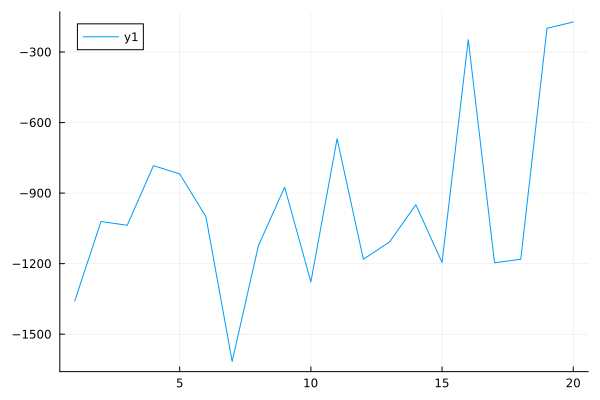

In [ ]:
### Plot the stuff
plot(episode_test_reward_hook.rewards)

In [ ]:
close_visualization(); # closes the MeshCat visualization